# Experiments for Masters's Program in Business Informatics University of Mannheim
This notebook contains the experiments performed on the Masters's program in business informatics at the University of Mannheim

## 1. Imports

In [45]:
import camelot
import pandas as pd
import tableExtraction as te
import graphCreation as gc
import re
import networkx as nx
import matplotlib.pyplot as plt

## 2. Create Graph
### 2.1 Extract Course Tables from Module Handbooks

In [2]:
relevant_courses = te.get_relevant_courses("../02_Ressources/MK_MSc_Wifo_neue_PO_2020_21_CourseOverview.pdf")
courses = te.get_courses("../02_Ressources/MK_MSc_Wifo_neue_PO_2020_21_Courses.pdf")


paths = ["../02_Ressources/Modulkatalog_MMM_Deutsch_abHWS2020.pdf"]
end_cells = [r"Range of application|Verwendbarkeit"]
coordinates = [[0,0]]
bwl_range = [["ACC", "TAX", "FIN", "MAN", "MKT", "OPM"], ["5", "6"]]
courses.extend(te.get_additional_courses(relevant_courses, paths, end_cells, coordinates, bwl_range))
#courses_BWL = te.get_additional_courses(relevant_courses, paths, end_cells, coordinates, bwl_range)

C:\Users\Paul\anaconda3\envs\master_thesis\lib\site-packages\camelot\utils.py:740: UserWarning:   (529.9550507738653, 530.0030525768653) does not lie in column range (71.265635564094, 528.1335517976622)
  warnings.warn(
C:\Users\Paul\anaconda3\envs\master_thesis\lib\site-packages\camelot\utils.py:740: UserWarning:   (529.6098477449448, 529.6578495479448) does not lie in column range (71.20564811265618, 528.2535276158808)
  warnings.warn(
C:\Users\Paul\anaconda3\envs\master_thesis\lib\site-packages\camelot\utils.py:740: UserWarning:   (540.621295177622, 540.669296980622) does not lie in column range (71.265635564094, 538.6914238008867)
  warnings.warn(
C:\Users\Paul\anaconda3\envs\master_thesis\lib\site-packages\camelot\utils.py:740: UserWarning:   (528.592483966372, 528.640485769372) does not lie in column range (71.265635564094, 528.1335517976622)
  warnings.warn(


courses = te.post_fixes(courses)

index = 0
for course in courses:
    name = "../03_Courses/" + "Course" + str(index) + ".xlsx"
    course.to_excel(name, index=False)
    index += 1

In [53]:
#import courses

courses = []
for i in range(0,171):
    path = "../03_Courses/Course" + str(i) + ".xlsx"
    df = pd.read_excel(path, dtype=str).fillna('')
    courses.append(df)

### 2.2 Creation of Nodes & Edges

In [54]:
G = nx.DiGraph()

course_nodes = gc.getCourseNodes(courses)
knowledge_nodes = pd.read_excel("../04_Graph/knowledgeAreas.xlsx").values.tolist()
edges_df = pd.read_excel("../04_Graph/edges.xlsx")
edges = edges_df.values.tolist()

In [55]:
#Create Course Nodes
for node in course_nodes:
    G.add_node(node[0], ECTS=node[1], offering_cycle=node[2], color="grey", type="course", active = False)

#Create Skill Nodes
for i in range(len(knowledge_nodes)):
    if i <= 16:
        G.add_node(knowledge_nodes[i][0], color="blue", type="skill", active = False)
    elif i > 16 and i <= 22:
        G.add_node(knowledge_nodes[i][0], color="green", type="skill", active = False)
    else:
        G.add_node(knowledge_nodes[i][0], color="brown", type="skill", active = False)

names = []

In [56]:
#Load manually created course -> skill edges
for edge in edges:
   G.add_edge(edge[0], edge[1], active = False)

additional_edges, additional_nodes = gc.complete_edges(courses, edges_df)

for node in additional_nodes:
    G.add_node(node[0], color = node[1], type = node[2], subtype = node[3], active = False)

for edge in additional_edges:
    if len(edge) <= 2:
        G.add_edge(edge[0], edge[1], active = False)
    else:
        G.add_edge(edge[0], edge[1], weight = edge[2], active = False)

In [57]:
#Set weights for parallel prerequiste course dependency
G.edges["FIN 540 Corporate Finance I - Lecture (Capital Structure, Cost of Capital and Valuation)",
"FIN 541 Corporate Finance I - Case Study (Capital Structure, Cost of Capital and Valuation)"]["weight"] = 3

G.edges["IS 512 IT Management in the Digital Age", "IS 513 Applied IT Management in the Digital Age"]["weight"] = 3

G.edges["IS 615 Design Thinking and Lean Development in Enterprise Software Development", 
"IS 613 Applied Project in Design Thinking and Lean Software Development"]["weight"] = 3

for outgoing, ingoing, data in G.edges(data=True):
    if outgoing == "OR 2" or ingoing == "OR 2" or outgoing == "OR 3" or ingoing == "OR 3":
        data["weight"] = 3

In [58]:
#Add complex prerequisite dependencies

#ACC 626 
G.add_node("OR 5", color = "white", type = "prerequisite_gate", subtype = "OR", active = False)
G.add_node("MIN 0", color = "white", type = "prerequisite_gate", subtype = "MIN", amount = 2, active = False)
G.add_edge("OR 5", "ACC 626 Transaction Accounting", weight = 2, active = False)
G.add_edge("ACC 520 IFRS Accounting and Capital Markets", "OR 5", weight = 2, active = False)
G.add_edge("ACC 530 Group Accounting", "OR 5", weight = 2, active = False)
G.add_edge("MIN 0", "OR 5", weight = 2, active = False)
G.add_edge("ACC 510 Jahresabschluss", "MIN 0", weight = 2, active = False)
G.add_edge("ACC 540 Financial Statement Analysis & Equity Valuation", "MIN 0", weight = 2, active = False)
G.add_edge("ACC 560 Managerial Accounting", "MIN 0", weight = 2, active = False)

#ACC 628 
G.add_node("OR 6", color = "white", type = "prerequisite_gate", subtype = "OR", active = False)
G.add_node("MIN 1", color = "white", type = "prerequisite_gate", subtype = "MIN", amount = 2, active = False)
G.add_edge("OR 6", "ACC 628 Selected Issues in IFRS Accounting", weight = 2, active = False)
G.add_edge("ACC 520 IFRS Accounting and Capital Markets", "OR 6", weight = 2, active = False)
G.add_edge("MIN 1", "OR 6", weight = 2, active = False)
G.add_edge("ACC 510 Jahresabschluss", "MIN 1", weight = 2, active = False)
G.add_edge("ACC 530 Group Accounting", "MIN 1", weight = 2, active = False)
G.add_edge("ACC 540 Financial Statement Analysis & Equity Valuation", "MIN 1", weight = 2, active = False)
G.add_edge("ACC 560 Managerial Accounting", "MIN 1", weight = 2, active = False)

#ACC 632 
G.add_node("OR 7", color = "white", type = "prerequisite_gate", subtype = "OR", active = False)
G.add_node("MIN 2", color = "white", type = "prerequisite_gate", subtype = "MIN", amount = 2, active = False)
G.add_edge("OR 7", "ACC 632 Konzernrechnungslegungspraxis", weight = 2, active = False)
G.add_edge("ACC 530 Group Accounting", "OR 7", weight = 2, active = False)
G.add_edge("MIN 2", "OR 7", weight = 2, active = False)
G.add_edge("ACC 510 Jahresabschluss", "MIN 2", weight = 2, active = False)
G.add_edge("ACC 520 IFRS Accounting and Capital Markets", "MIN 2", weight = 2, active = False)
G.add_edge("ACC 540 Financial Statement Analysis & Equity Valuation", "MIN 2", weight = 2, active = False)
G.add_edge("ACC 560 Managerial Accounting", "MIN 2", weight = 2, active = False)


In [59]:
#Quality Checks for Attribute values

for node, data in G.nodes(data=True):
    #print(f"Knoten {node}: name = {data.get('offering_cycle')}")
    print(data.get('offering_cycle'))
    #if not (data.get('offering_cycle') == "FWS" or data.get('offering_cycle') =="SSS" or data.get('offering_cycle') == "Continuously"):
        #print(f"Knoten {node}: name = {data.get('offering_cycle')}")
    #print(f"Knoten {node}: name = {data.get('ECTS')}")

#for outgoing, ingoing, data in G.edges(data=True):
#    print(f"{outgoing} -> {ingoing}: weight = {data.get('weight')}")

#for outgoing, ingoing, data in G.edges(data=True):
#    if "OR 3" in outgoing or "OR 3" in ingoing:
#        print(f"{outgoing} -> {ingoing}: weight = {data.get('weight')}")

FWS
SSS
Continuously
FWS
Continuously
FWS
FWS
Continuously
SSS
FWS
FWS
SSS
FWS
SSS
FWS
FWS
SSS
FWS
SSS
SSS
SSS
FWS
FWS
SSS
FWS
SSS
FWS
Continuously
Continuously
SSS
Continuously
Continuously
Continuously
Continuously
Continuously
SSS
SSS
FWS
FWS
FWS
FWS
Continuously
Continuously
Continuously
SSS
FWS
FWS
SSS
SSS
FWS
SSS
FWS
SSS
SSS
FWS
Continuously
FWS
FWS
SSS
SSS
FWS
FWS
SSS
SSS
FWS
SSS
FWS
FWS
FWS
SSS
FWS
SSS
FWS
FWS
SSS
FWS
SSS
Continuously
FWS
SSS
FWS
SSS
Continuously
SSS
SSS
SSS
SSS
SSS
SSS
SSS
FWS
FWS
SSS
FWS
FWS
FWS
FWS
FWS
FWS
SSS
SSS
Continuously
Continuously
Continuously
Continuously
FWS
FWS
SSS
Continuously
FWS
SSS
SSS
FWS
FWS
SSS
SSS
FWS
SSS
SSS
FWS
FWS
FWS
SSS
SSS
SSS
FWS
SSS
FWS
SSS
SSS
SSS
FWS
FWS
FWS
FWS
SSS
SSS
SSS
SSS
FWS
SSS
FWS
SSS
FWS
FWS
SSS
SSS
SSS
FWS
SSS
SSS
FWS
FWS
FWS
SSS
FWS
SSS
FWS
FWS
SSS
SSS
SSS
FWS
FWS
SSS
FWS
SSS
SSS
FWS
SSS
SSS
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
No

In [34]:
print(G.nodes)

['CS 500 Advanced Software Engineering', 'CS 530 Database Systems II (DBSII)', 'CS 550 Algorithmics', 'CS 560 Large-Scale Data Management', 'IE 500 Data Mining I', 'IE 560 Decision Support', 'CS 600 Model Driven Development', 'CS 605 GPU Programming', 'CS 646 Higher Level Computer Vision', 'CS 647 Image Processing', 'CS 651 Kryptographie II', 'CS 652 Data Security', 'CS 654 Internet of Things Security', 'IE 630 Query Optimization', 'IE 650 Semantic Web Technologies', 'IE 661 Text Analytics', 'IE 663 Information Retrieval and Web Search', 'IE 670 Web Data Integration', 'IE 671 Web Mining', 'IE 672 Data Mining II', 'IE 674 Hot Topics in Machine Learning', 'IE 675 Machine Learning', 'IE 676 Network Analysis', 'IE 691 Information Retrieval Project', 'IE 683 Web Data Integration Project', 'IE 684 Web Mining Project', 'IE 689 Relational Learning', 'TP 500 Team Project', 'SQ 500 Scientific Research', 'CS 701 Selected Topics in Algorithmics and Cryptography', 'CS 704 Master Seminar Artificial 

<function matplotlib.pyplot.show(close=None, block=None)>

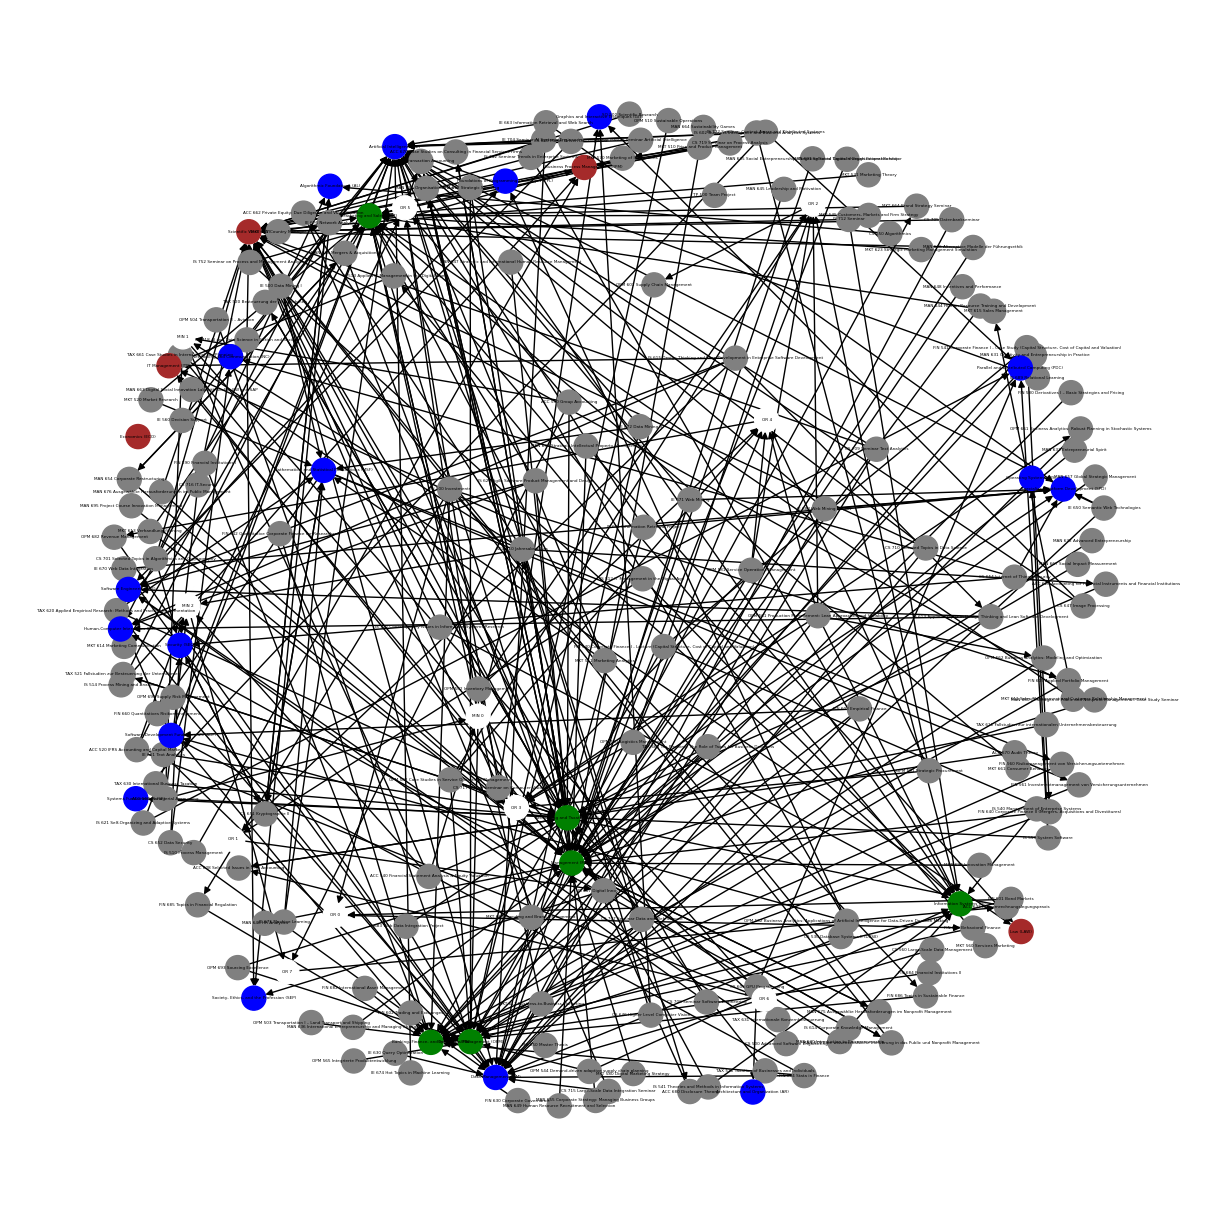

In [24]:
pos = nx.spring_layout(G, k=1) 

plt.figure(figsize=(12, 12))

node_colors = [G.nodes[node]['color'] for node in G.nodes()]

nx.draw(G, pos, with_labels=True, node_color=node_colors, font_size=3)

#nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)
plt.savefig("graph.pdf", format="pdf") 
plt.show

### 2.2 Creation of Knowledge Areas

In [13]:
#append knowledge field for analysis

#fields containing information about knowledge areas
fields = ["Lehrinhalte", "Lern- und Kompetenzziele", "Lern- und Qualifikationsziele", "Vorausgesetzte Kenntnisse"]
courses = te.append_raw_knowledge_field(fields, courses)

In [14]:
#combine all raw_knowledge_fields

raw_knowledge_combined = ""
for course in courses:
    raw_knowledge_combined += course.iloc[len(course)-1,1] + " "

cleaned_raw_knowledge_combined = re.sub(r'\s*-\s*', ' ', raw_knowledge_combined).replace('-', '')


NameError: name 'nlp' is not defined

In [17]:
from transformers import pipeline

# NER Pipeline laden
ner_pipeline = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english")

# Skills im Text extrahieren
ner_results = ner_pipeline(cleaned_raw_knowledge_combined)
print(ner_results)
skills = [result['word'] for result in ner_results if result['entity'] == 'I-MISC']

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'entity': 'I-MISC', 'score': 0.5857197, 'index': 47, 'word': 'W', 'start': 126, 'end': 127}, {'entity': 'I-MISC', 'score': 0.53814673, 'index': 49, 'word': '##sch', 'start': 130, 'end': 133}, {'entity': 'I-MISC', 'score': 0.8541129, 'index': 188, 'word': 'Ben', 'start': 521, 'end': 524}, {'entity': 'I-MISC', 'score': 0.4742797, 'index': 243, 'word': '##aft', 'start': 671, 'end': 674}, {'entity': 'I-MISC', 'score': 0.6192035, 'index': 257, 'word': 'Information', 'start': 711, 'end': 722}, {'entity': 'I-ORG', 'score': 0.60637033, 'index': 327, 'word': 'Ke', 'start': 898, 'end': 900}, {'entity': 'I-ORG', 'score': 0.41567594, 'index': 328, 'word': '##ine', 'start': 900, 'end': 903}, {'entity': 'I-ORG', 'score': 0.44517997, 'index': 368, 'word': 'Roll', 'start': 1007, 'end': 1011}, {'entity': 'I-MISC', 'score': 0.57943016, 'index': 381, 'word': 'W', 'start': 1047, 'end': 1048}]


In [11]:
print(skills)

['Python']
